In [56]:
%run 'Data Cleaning.ipynb'

In [57]:
jobs_cleaned.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped,skill_name,industry_name
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,63000.0,NaN,MONTHLY,Full-time,"Little River, SC",...,NaN,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101,Other,Medical Equipment Manufacturing
4,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,46321.6,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461,Management,Non-profit Organizations
5,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,46321.6,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461,Manufacturing,Non-profit Organizations
6,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,240895.0,205956.0,YEARLY,Full-time,United States,...,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology,"Technology, Information and Internet"
7,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,240895.0,205956.0,YEARLY,Full-time,United States,...,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology,Manufacturing


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

med_P = np.nanpercentile(jobs_cleaned['med_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['med_salary'] > med_P[0]) & (jobs_cleaned['med_salary'] < med_P[1])]

min_P = np.nanpercentile(jobs_cleaned['min_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['min_salary'] > min_P[0]) & (jobs_cleaned['min_salary'] < min_P[1])]

max_P = np.nanpercentile(jobs_cleaned['max_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['min_salary'] > max_P[0]) & (jobs_cleaned['min_salary'] < max_P[1])]

# Create a new LabelEncoder for each categorical column
title_encoder = LabelEncoder()
location_encoder = LabelEncoder()
skill_name_encoder = LabelEncoder()
experience_level_encoder = LabelEncoder()

# Fit and transform each column with its respective encoder
jobs_cleaned['title_enc'] = title_encoder.fit_transform(jobs_cleaned['title'])
jobs_cleaned['location_enc'] = location_encoder.fit_transform(jobs_cleaned['location'])
jobs_cleaned['skill_name_enc'] = skill_name_encoder.fit_transform(jobs_cleaned['skill_name'])
jobs_cleaned['formatted_experience_level_enc'] = experience_level_encoder.fit_transform(jobs_cleaned['formatted_experience_level'])


X = jobs_cleaned[['title_enc', 'location_enc','skill_name_enc','formatted_experience_level_enc']]


## XGBoost

In [72]:
def train_salary_model(salary_level):
    # Select the salary level for prediction
    y = jobs_cleaned[salary_level]
    
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Initializing and training the XGBoost regressor model
    # After running a few grid searches I found that each model had the same best parameters
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2,
                              max_depth = 5, n_estimators = 1000)
    xg_reg.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = xg_reg.predict(X_test)

    # Calculating the RMSE for the predictions
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    
    # Returning the trained model
    return xg_reg, salary_level, y_test, y_pred, rmse

In [70]:
def model_eval(model, salary_level, y_test, y_pred, rmse):

    print(f"Salary Level: {salary_level}")
    print(f"RMSE: {rmse}")
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Salaries')
    plt.ylabel('Predicted Salaries')
    plt.title(f'Actual vs. Predicted Salaries ({salary_level})')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.show()

Salary Level: min_salary
RMSE: 19820.9748180707


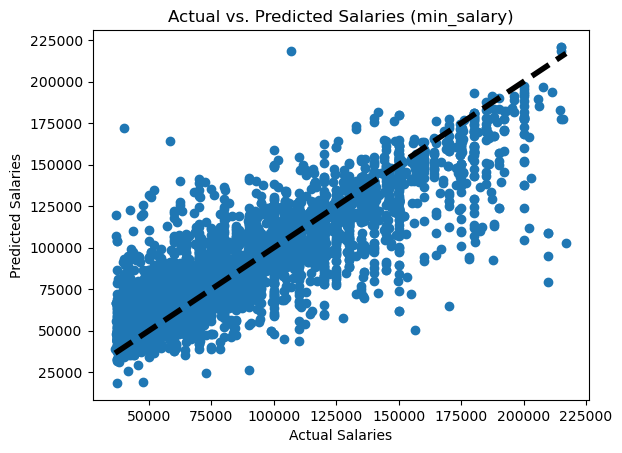

Salary Level: max_salary
RMSE: 33348.67012218484


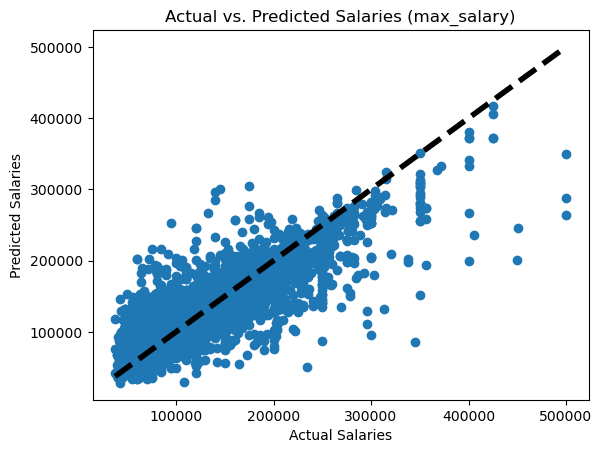

Salary Level: med_salary
RMSE: 25061.2225622539


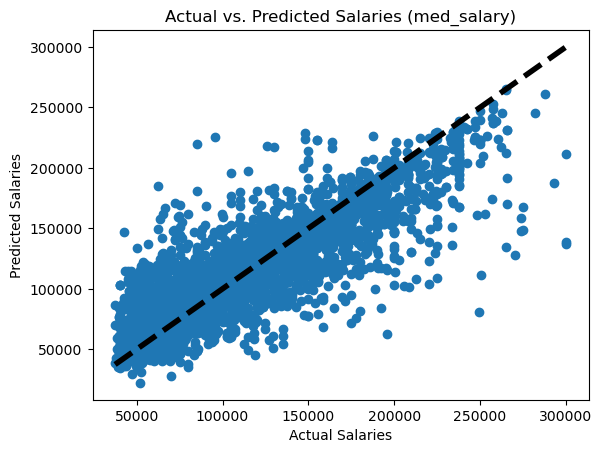

In [71]:
models = ['min_salary','max_salary','med_salary']
for model in models:
    model_eval(*train_salary_model(model))

### Min, Median, Max estimator

In [62]:
med_salary_model, _, _, _, _ = train_salary_model('med_salary')
min_salary_model, _, _, _, _ = train_salary_model('min_salary')
max_salary_model, _, _, _, _ = train_salary_model('max_salary')

# Example user input
for location in jobs_cleaned['location'].unique():
    user_input = {
        'title_enc': ['Senior Data Analyst'],
        'location_enc': [f'{location}'],
        'skill_name_enc': ['Information Technology'],
        'formatted_experience_level_enc': ['Mid-Senior level']
    }

    user_input_df = pd.DataFrame(user_input)

    user_input_df['title_enc'] = title_encoder.transform(user_input_df['title_enc'])
    user_input_df['location_enc'] = location_encoder.transform(user_input_df['location_enc'])
    user_input_df['skill_name_enc'] = skill_name_encoder.transform(user_input_df['skill_name_enc'])
    user_input_df['formatted_experience_level_enc'] = experience_level_encoder.transform(user_input_df['formatted_experience_level_enc'])

    # Predict the salary for the user input
    min_predicted_salary = min_salary_model.predict(user_input_df)
    median_predicted_salary = med_salary_model.predict(user_input_df)
    max_predicted_salary = max_salary_model.predict(user_input_df)

    print(f"----{location}-----")
    print(f"Minimum Estimated salary: {min_predicted_salary[0]:.2f} USD/year")
    print(f"Median Estimated salary: {median_predicted_salary[0]:.2f} USD/year")
    print(f"Maximum Estimated salary: {max_predicted_salary[0]:.2f} USD/year")
    

----United States-----
Minimum Estimated salary: 122319.98 USD/year
Median Estimated salary: 135259.56 USD/year
Maximum Estimated salary: 142826.83 USD/year
----Coeur d'Alene, ID-----
Minimum Estimated salary: 96018.73 USD/year
Median Estimated salary: 114159.26 USD/year
Maximum Estimated salary: 138475.30 USD/year
----Waukesha, WI-----
Minimum Estimated salary: 105275.99 USD/year
Median Estimated salary: 129962.46 USD/year
Maximum Estimated salary: 146581.81 USD/year
----Orlando, FL-----
Minimum Estimated salary: 91874.69 USD/year
Median Estimated salary: 128646.08 USD/year
Maximum Estimated salary: 145499.62 USD/year
----Oakland, CA-----
Minimum Estimated salary: 101344.85 USD/year
Median Estimated salary: 132250.72 USD/year
Maximum Estimated salary: 154840.14 USD/year
----Broomfield, CO-----
Minimum Estimated salary: 96060.31 USD/year
Median Estimated salary: 126868.93 USD/year
Maximum Estimated salary: 144297.02 USD/year
----Swedesboro, NJ-----
Minimum Estimated salary: 128575.70 U

----Seattle, WA-----
Minimum Estimated salary: 132203.73 USD/year
Median Estimated salary: 162564.31 USD/year
Maximum Estimated salary: 189418.39 USD/year
----Fresno, CA-----
Minimum Estimated salary: 102589.92 USD/year
Median Estimated salary: 134281.22 USD/year
Maximum Estimated salary: 167530.50 USD/year
----Charleston, SC-----
Minimum Estimated salary: 107850.98 USD/year
Median Estimated salary: 134502.58 USD/year
Maximum Estimated salary: 172272.81 USD/year
----Durham, NC-----
Minimum Estimated salary: 113320.66 USD/year
Median Estimated salary: 141327.11 USD/year
Maximum Estimated salary: 165746.36 USD/year
----Wilmington, Delaware, United States-----
Minimum Estimated salary: 118813.01 USD/year
Median Estimated salary: 127465.89 USD/year
Maximum Estimated salary: 155025.28 USD/year
----Oceanside, CA-----
Minimum Estimated salary: 101344.85 USD/year
Median Estimated salary: 132250.72 USD/year
Maximum Estimated salary: 154840.14 USD/year
----Lake Forest, IL-----
Minimum Estimated 

----Edmond, OK-----
Minimum Estimated salary: 108020.83 USD/year
Median Estimated salary: 147704.28 USD/year
Maximum Estimated salary: 180863.23 USD/year
----Las Vegas, NV-----
Minimum Estimated salary: 94998.86 USD/year
Median Estimated salary: 112886.79 USD/year
Maximum Estimated salary: 129089.67 USD/year
----Fort Morgan, CO-----
Minimum Estimated salary: 109140.02 USD/year
Median Estimated salary: 136904.80 USD/year
Maximum Estimated salary: 160027.02 USD/year
----Chandler, AZ-----
Minimum Estimated salary: 110851.98 USD/year
Median Estimated salary: 144371.48 USD/year
Maximum Estimated salary: 208645.73 USD/year
----Sandy, UT-----
Minimum Estimated salary: 156133.84 USD/year
Median Estimated salary: 183641.31 USD/year
Maximum Estimated salary: 186961.75 USD/year
----North Las Vegas, NV-----
Minimum Estimated salary: 90762.95 USD/year
Median Estimated salary: 119379.88 USD/year
Maximum Estimated salary: 135539.17 USD/year
----Plano, TX-----
Minimum Estimated salary: 113472.84 USD/y

----Redmond, WA-----
Minimum Estimated salary: 108170.37 USD/year
Median Estimated salary: 152099.45 USD/year
Maximum Estimated salary: 177377.48 USD/year
----Westport, CT-----
Minimum Estimated salary: 98511.51 USD/year
Median Estimated salary: 119166.06 USD/year
Maximum Estimated salary: 127540.77 USD/year
----Tualatin, OR-----
Minimum Estimated salary: 104409.34 USD/year
Median Estimated salary: 125680.30 USD/year
Maximum Estimated salary: 138835.75 USD/year
----San Carlos, CA-----
Minimum Estimated salary: 127877.27 USD/year
Median Estimated salary: 154033.41 USD/year
Maximum Estimated salary: 169184.59 USD/year
----Yreka, CA-----
Minimum Estimated salary: 100853.39 USD/year
Median Estimated salary: 133200.12 USD/year
Maximum Estimated salary: 150809.95 USD/year
----Maple Grove, MN-----
Minimum Estimated salary: 106917.81 USD/year
Median Estimated salary: 144046.55 USD/year
Maximum Estimated salary: 163864.95 USD/year
----San Marcos, CA-----
Minimum Estimated salary: 121482.70 USD/

----Albuquerque, NM-----
Minimum Estimated salary: 106070.17 USD/year
Median Estimated salary: 138981.73 USD/year
Maximum Estimated salary: 166275.05 USD/year
----Hartford, CT-----
Minimum Estimated salary: 97475.77 USD/year
Median Estimated salary: 122135.87 USD/year
Maximum Estimated salary: 141289.61 USD/year
----West Coxsackie, NY-----
Minimum Estimated salary: 103851.73 USD/year
Median Estimated salary: 127787.80 USD/year
Maximum Estimated salary: 140436.36 USD/year
----Merced, CA-----
Minimum Estimated salary: 88209.41 USD/year
Median Estimated salary: 112648.38 USD/year
Maximum Estimated salary: 140765.14 USD/year
----Illinois, United States-----
Minimum Estimated salary: 104836.86 USD/year
Median Estimated salary: 132895.84 USD/year
Maximum Estimated salary: 156064.53 USD/year
----Akron, OH-----
Minimum Estimated salary: 118527.38 USD/year
Median Estimated salary: 137019.45 USD/year
Maximum Estimated salary: 163981.58 USD/year
----Sterling, VA-----
Minimum Estimated salary: 116

----East Durham, NY-----
Minimum Estimated salary: 113320.66 USD/year
Median Estimated salary: 141327.11 USD/year
Maximum Estimated salary: 165746.36 USD/year
----Woodbridge, NJ-----
Minimum Estimated salary: 80013.96 USD/year
Median Estimated salary: 101154.28 USD/year
Maximum Estimated salary: 106567.46 USD/year
----West Virginia, United States-----
Minimum Estimated salary: 98511.51 USD/year
Median Estimated salary: 119166.06 USD/year
Maximum Estimated salary: 127540.77 USD/year
----Aliso Viejo, CA-----
Minimum Estimated salary: 117504.45 USD/year
Median Estimated salary: 144731.33 USD/year
Maximum Estimated salary: 163220.17 USD/year
----Newark, OH-----
Minimum Estimated salary: 97964.76 USD/year
Median Estimated salary: 132267.31 USD/year
Maximum Estimated salary: 157703.11 USD/year
----Evansville, IN-----
Minimum Estimated salary: 104783.00 USD/year
Median Estimated salary: 123132.50 USD/year
Maximum Estimated salary: 153203.45 USD/year
----Stamford, CT-----
Minimum Estimated sal

----Somersworth, NH-----
Minimum Estimated salary: 119662.91 USD/year
Median Estimated salary: 149952.73 USD/year
Maximum Estimated salary: 167603.09 USD/year
----Tilton, NH-----
Minimum Estimated salary: 101508.44 USD/year
Median Estimated salary: 122223.45 USD/year
Maximum Estimated salary: 132319.50 USD/year
----Dunwoody, GA-----
Minimum Estimated salary: 113955.64 USD/year
Median Estimated salary: 135367.00 USD/year
Maximum Estimated salary: 157970.48 USD/year
----Mechanicsville, VA-----
Minimum Estimated salary: 92221.41 USD/year
Median Estimated salary: 120531.86 USD/year
Maximum Estimated salary: 156151.14 USD/year
----North Myrtle Beach, SC-----
Minimum Estimated salary: 90762.95 USD/year
Median Estimated salary: 119379.88 USD/year
Maximum Estimated salary: 135539.17 USD/year
----Norcross, GA-----
Minimum Estimated salary: 89930.91 USD/year
Median Estimated salary: 122983.89 USD/year
Maximum Estimated salary: 147286.45 USD/year
----Middlebury, VT-----
Minimum Estimated salary: 

----Beavercreek, OH-----
Minimum Estimated salary: 88043.52 USD/year
Median Estimated salary: 125088.88 USD/year
Maximum Estimated salary: 145205.94 USD/year
----Atwater, CA-----
Minimum Estimated salary: 112267.67 USD/year
Median Estimated salary: 135800.66 USD/year
Maximum Estimated salary: 161173.38 USD/year
----Forest Park, IL-----
Minimum Estimated salary: 102521.16 USD/year
Median Estimated salary: 143669.03 USD/year
Maximum Estimated salary: 180378.42 USD/year
----Chino, CA-----
Minimum Estimated salary: 107289.77 USD/year
Median Estimated salary: 121864.85 USD/year
Maximum Estimated salary: 150287.73 USD/year
----Tok, AK-----
Minimum Estimated salary: 101508.44 USD/year
Median Estimated salary: 122223.45 USD/year
Maximum Estimated salary: 132319.50 USD/year
----Griffin, GA-----
Minimum Estimated salary: 103988.04 USD/year
Median Estimated salary: 136678.42 USD/year
Maximum Estimated salary: 150479.22 USD/year
----New Brunswick, NJ-----
Minimum Estimated salary: 88019.48 USD/yea

----La Jolla, California, United States-----
Minimum Estimated salary: 110513.66 USD/year
Median Estimated salary: 142026.03 USD/year
Maximum Estimated salary: 167576.30 USD/year
----Maitland, FL-----
Minimum Estimated salary: 124241.25 USD/year
Median Estimated salary: 158556.52 USD/year
Maximum Estimated salary: 174415.12 USD/year
----Grand Junction, CO-----
Minimum Estimated salary: 106381.77 USD/year
Median Estimated salary: 127103.78 USD/year
Maximum Estimated salary: 146415.94 USD/year
----Lawrence, MA-----
Minimum Estimated salary: 94998.86 USD/year
Median Estimated salary: 112886.79 USD/year
Maximum Estimated salary: 129089.67 USD/year
----Miami-Dade County, FL-----
Minimum Estimated salary: 86120.80 USD/year
Median Estimated salary: 114280.90 USD/year
Maximum Estimated salary: 140400.30 USD/year
----Albany, GA-----
Minimum Estimated salary: 118527.38 USD/year
Median Estimated salary: 137019.45 USD/year
Maximum Estimated salary: 163981.58 USD/year
----Newnan, GA-----
Minimum Es

----New Castle, DE-----
Minimum Estimated salary: 88019.48 USD/year
Median Estimated salary: 113290.91 USD/year
Maximum Estimated salary: 141801.84 USD/year
----Monticello, GA-----
Minimum Estimated salary: 92910.24 USD/year
Median Estimated salary: 109149.80 USD/year
Maximum Estimated salary: 121406.24 USD/year
----Noblesville, IN-----
Minimum Estimated salary: 89930.91 USD/year
Median Estimated salary: 122983.89 USD/year
Maximum Estimated salary: 147286.45 USD/year
----St Augustine, FL-----
Minimum Estimated salary: 108760.59 USD/year
Median Estimated salary: 131857.53 USD/year
Maximum Estimated salary: 138600.84 USD/year
----Greater Tampa Bay Area-----
Minimum Estimated salary: 94110.68 USD/year
Median Estimated salary: 122640.61 USD/year
Maximum Estimated salary: 129239.78 USD/year
----Patuxent River, MD-----
Minimum Estimated salary: 99360.90 USD/year
Median Estimated salary: 121744.39 USD/year
Maximum Estimated salary: 131767.58 USD/year
----Buford, GA-----
Minimum Estimated sala

----Santa Rosa, CA-----
Minimum Estimated salary: 125437.75 USD/year
Median Estimated salary: 161622.94 USD/year
Maximum Estimated salary: 175161.17 USD/year
----Hegins, PA-----
Minimum Estimated salary: 97475.77 USD/year
Median Estimated salary: 122135.87 USD/year
Maximum Estimated salary: 141289.61 USD/year
----Massachusetts, United States-----
Minimum Estimated salary: 103938.44 USD/year
Median Estimated salary: 147013.14 USD/year
Maximum Estimated salary: 159508.53 USD/year
----Freeport, ME-----
Minimum Estimated salary: 101480.23 USD/year
Median Estimated salary: 124495.73 USD/year
Maximum Estimated salary: 143898.41 USD/year
----San Clemente, CA-----
Minimum Estimated salary: 127877.27 USD/year
Median Estimated salary: 154033.41 USD/year
Maximum Estimated salary: 169184.59 USD/year
----Columbia, MO-----
Minimum Estimated salary: 96579.37 USD/year
Median Estimated salary: 113365.29 USD/year
Maximum Estimated salary: 136755.42 USD/year
----Lakewood, CA-----
Minimum Estimated salary

----Loveland, CO-----
Minimum Estimated salary: 93815.35 USD/year
Median Estimated salary: 133391.50 USD/year
Maximum Estimated salary: 153158.61 USD/year
----Carbondale, CO-----
Minimum Estimated salary: 110217.07 USD/year
Median Estimated salary: 145540.19 USD/year
Maximum Estimated salary: 163744.14 USD/year
----Redmond, OR-----
Minimum Estimated salary: 108170.37 USD/year
Median Estimated salary: 152099.45 USD/year
Maximum Estimated salary: 177377.48 USD/year
----Severn, MD-----
Minimum Estimated salary: 132203.73 USD/year
Median Estimated salary: 162564.31 USD/year
Maximum Estimated salary: 189418.39 USD/year
----Tipton, IN-----
Minimum Estimated salary: 101508.44 USD/year
Median Estimated salary: 122223.45 USD/year
Maximum Estimated salary: 132319.50 USD/year
----Carrollton, GA-----
Minimum Estimated salary: 105843.41 USD/year
Median Estimated salary: 151074.03 USD/year
Maximum Estimated salary: 179751.61 USD/year
----West Point, MS-----
Minimum Estimated salary: 98511.51 USD/yea

----Longview, WA-----
Minimum Estimated salary: 98662.69 USD/year
Median Estimated salary: 128197.45 USD/year
Maximum Estimated salary: 165322.38 USD/year
----Colonial Heights, VA-----
Minimum Estimated salary: 96018.73 USD/year
Median Estimated salary: 114159.26 USD/year
Maximum Estimated salary: 138475.30 USD/year
----Cedar Creek, TX-----
Minimum Estimated salary: 110851.98 USD/year
Median Estimated salary: 144371.48 USD/year
Maximum Estimated salary: 208645.73 USD/year
----Madison, NJ-----
Minimum Estimated salary: 124241.25 USD/year
Median Estimated salary: 158556.52 USD/year
Maximum Estimated salary: 174415.12 USD/year
----O'Fallon, MO-----
Minimum Estimated salary: 93054.42 USD/year
Median Estimated salary: 120690.40 USD/year
Maximum Estimated salary: 142159.52 USD/year
----Colchester, VT-----
Minimum Estimated salary: 96018.73 USD/year
Median Estimated salary: 114159.26 USD/year
Maximum Estimated salary: 138475.30 USD/year
----Steamboat Springs, CO-----
Minimum Estimated salary:

----Landover, MD-----
Minimum Estimated salary: 102290.97 USD/year
Median Estimated salary: 128303.69 USD/year
Maximum Estimated salary: 144990.20 USD/year
----Napa County, CA-----
Minimum Estimated salary: 129106.99 USD/year
Median Estimated salary: 169212.42 USD/year
Maximum Estimated salary: 200624.62 USD/year
----Cameron, TX-----
Minimum Estimated salary: 110217.07 USD/year
Median Estimated salary: 145540.19 USD/year
Maximum Estimated salary: 163744.14 USD/year
----San Rafael, CA-----
Minimum Estimated salary: 156133.84 USD/year
Median Estimated salary: 183641.31 USD/year
Maximum Estimated salary: 186961.75 USD/year
----Homewood, AL-----
Minimum Estimated salary: 103890.06 USD/year
Median Estimated salary: 119875.34 USD/year
Maximum Estimated salary: 152921.09 USD/year
----Greater Columbia, Missouri Area-----
Minimum Estimated salary: 103665.81 USD/year
Median Estimated salary: 109899.02 USD/year
Maximum Estimated salary: 124757.08 USD/year
----Round Rock, TX-----
Minimum Estimated

----Clifton Park, NY-----
Minimum Estimated salary: 96018.73 USD/year
Median Estimated salary: 114159.26 USD/year
Maximum Estimated salary: 138475.30 USD/year
----Spartanburg, SC-----
Minimum Estimated salary: 113781.41 USD/year
Median Estimated salary: 149157.69 USD/year
Maximum Estimated salary: 167620.72 USD/year
----Pinellas Park, FL-----
Minimum Estimated salary: 99679.80 USD/year
Median Estimated salary: 130146.64 USD/year
Maximum Estimated salary: 156475.67 USD/year
----Bullhead City, AZ-----
Minimum Estimated salary: 100594.22 USD/year
Median Estimated salary: 147830.12 USD/year
Maximum Estimated salary: 147007.09 USD/year
----Bellingham, WA-----
Minimum Estimated salary: 92472.32 USD/year
Median Estimated salary: 123079.14 USD/year
Maximum Estimated salary: 159738.48 USD/year
----Kansas City, KS-----
Minimum Estimated salary: 99155.84 USD/year
Median Estimated salary: 127355.02 USD/year
Maximum Estimated salary: 148934.12 USD/year
----Thornton, CO-----
Minimum Estimated salary

----Sun Valley, CA-----
Minimum Estimated salary: 114494.90 USD/year
Median Estimated salary: 146274.94 USD/year
Maximum Estimated salary: 169564.16 USD/year
----Roseville, CA-----
Minimum Estimated salary: 94978.81 USD/year
Median Estimated salary: 116286.13 USD/year
Maximum Estimated salary: 127890.24 USD/year
----Bluffdale, UT-----
Minimum Estimated salary: 79505.59 USD/year
Median Estimated salary: 98570.25 USD/year
Maximum Estimated salary: 126313.71 USD/year
----Stanford, CA-----
Minimum Estimated salary: 116854.43 USD/year
Median Estimated salary: 160429.05 USD/year
Maximum Estimated salary: 209840.39 USD/year
----Greenville County, SC-----
Minimum Estimated salary: 100309.74 USD/year
Median Estimated salary: 132184.97 USD/year
Maximum Estimated salary: 144738.67 USD/year
----Edwards, CA-----
Minimum Estimated salary: 108020.83 USD/year
Median Estimated salary: 147704.28 USD/year
Maximum Estimated salary: 180863.23 USD/year
----Lenox, IA-----
Minimum Estimated salary: 81984.67 U

----Monroe, LA-----
Minimum Estimated salary: 91679.97 USD/year
Median Estimated salary: 123989.70 USD/year
Maximum Estimated salary: 157497.86 USD/year
----Rio Rancho, NM-----
Minimum Estimated salary: 103488.92 USD/year
Median Estimated salary: 123046.93 USD/year
Maximum Estimated salary: 131331.39 USD/year
----Carpinteria, CA-----
Minimum Estimated salary: 105843.41 USD/year
Median Estimated salary: 151074.03 USD/year
Maximum Estimated salary: 179751.61 USD/year
----Artesia, MS-----
Minimum Estimated salary: 120610.37 USD/year
Median Estimated salary: 134637.64 USD/year
Maximum Estimated salary: 152619.72 USD/year
----Oakland, NJ-----
Minimum Estimated salary: 101344.85 USD/year
Median Estimated salary: 132250.72 USD/year
Maximum Estimated salary: 154840.14 USD/year
----Redwood Valley, CA-----
Minimum Estimated salary: 104933.99 USD/year
Median Estimated salary: 126495.98 USD/year
Maximum Estimated salary: 148398.44 USD/year
----San Bruno, CA-----
Minimum Estimated salary: 127877.27

----Dover, NJ-----
Minimum Estimated salary: 113523.56 USD/year
Median Estimated salary: 144494.73 USD/year
Maximum Estimated salary: 165833.56 USD/year
----North Dakota, United States-----
Minimum Estimated salary: 90762.95 USD/year
Median Estimated salary: 119379.88 USD/year
Maximum Estimated salary: 135539.17 USD/year
----Rhode Island, United States-----
Minimum Estimated salary: 104933.99 USD/year
Median Estimated salary: 126495.98 USD/year
Maximum Estimated salary: 148398.44 USD/year
----Medina, OH-----
Minimum Estimated salary: 92221.41 USD/year
Median Estimated salary: 120531.86 USD/year
Maximum Estimated salary: 156151.14 USD/year
----Clara City, MN-----
Minimum Estimated salary: 102922.29 USD/year
Median Estimated salary: 124918.12 USD/year
Maximum Estimated salary: 149157.23 USD/year
----Jamison, PA-----
Minimum Estimated salary: 93501.76 USD/year
Median Estimated salary: 109037.70 USD/year
Maximum Estimated salary: 125567.94 USD/year
----Lewisville, TX-----
Minimum Estimated

----Clinton, SC-----
Minimum Estimated salary: 96018.73 USD/year
Median Estimated salary: 114159.26 USD/year
Maximum Estimated salary: 138475.30 USD/year
----Blue Bell, PA-----
Minimum Estimated salary: 79505.59 USD/year
Median Estimated salary: 98570.25 USD/year
Maximum Estimated salary: 126313.71 USD/year
----McDonough, GA-----
Minimum Estimated salary: 103938.44 USD/year
Median Estimated salary: 147013.14 USD/year
Maximum Estimated salary: 159508.53 USD/year
----Bath, PA-----
Minimum Estimated salary: 88043.52 USD/year
Median Estimated salary: 125088.88 USD/year
Maximum Estimated salary: 145205.94 USD/year
----Turlock, CA-----
Minimum Estimated salary: 93301.30 USD/year
Median Estimated salary: 105740.62 USD/year
Maximum Estimated salary: 122294.27 USD/year
----Windsor, CO-----
Minimum Estimated salary: 80013.96 USD/year
Median Estimated salary: 101154.28 USD/year
Maximum Estimated salary: 106567.46 USD/year
----Rolla, MO-----
Minimum Estimated salary: 92826.70 USD/year
Median Estim

----Bridgeport, AL-----
Minimum Estimated salary: 98630.14 USD/year
Median Estimated salary: 119055.35 USD/year
Maximum Estimated salary: 135309.98 USD/year
----Goodland, KS-----
Minimum Estimated salary: 106381.77 USD/year
Median Estimated salary: 127103.78 USD/year
Maximum Estimated salary: 146415.94 USD/year
----Antigo, WI-----
Minimum Estimated salary: 120647.85 USD/year
Median Estimated salary: 131610.41 USD/year
Maximum Estimated salary: 152219.98 USD/year
----Roseburg, OR-----
Minimum Estimated salary: 92826.70 USD/year
Median Estimated salary: 113998.80 USD/year
Maximum Estimated salary: 126054.65 USD/year
----Barstow, CA-----
Minimum Estimated salary: 87225.95 USD/year
Median Estimated salary: 109892.73 USD/year
Maximum Estimated salary: 131235.83 USD/year
----West Covina, CA-----
Minimum Estimated salary: 103851.73 USD/year
Median Estimated salary: 127787.80 USD/year
Maximum Estimated salary: 140436.36 USD/year
----Bernardsville, NJ-----
Minimum Estimated salary: 93110.23 USD

----Walbridge, OH-----
Minimum Estimated salary: 98395.84 USD/year
Median Estimated salary: 114341.64 USD/year
Maximum Estimated salary: 131598.45 USD/year
----La Mesa, CA-----
Minimum Estimated salary: 110513.66 USD/year
Median Estimated salary: 142026.03 USD/year
Maximum Estimated salary: 167576.30 USD/year
----Mitchellville, MD-----
Minimum Estimated salary: 91679.97 USD/year
Median Estimated salary: 123989.70 USD/year
Maximum Estimated salary: 157497.86 USD/year
----Mesquite, Texas, United States-----
Minimum Estimated salary: 69080.76 USD/year
Median Estimated salary: 106326.59 USD/year
Maximum Estimated salary: 131216.23 USD/year
----Smyrna, GA-----
Minimum Estimated salary: 119662.91 USD/year
Median Estimated salary: 149952.73 USD/year
Maximum Estimated salary: 167603.09 USD/year
----Aurora, Colorado, United States-----
Minimum Estimated salary: 112267.67 USD/year
Median Estimated salary: 135800.66 USD/year
Maximum Estimated salary: 161173.38 USD/year
----Santa Clara County, CA-

----Batavia, NY-----
Minimum Estimated salary: 88043.52 USD/year
Median Estimated salary: 125088.88 USD/year
Maximum Estimated salary: 145205.94 USD/year
----Florence, SC-----
Minimum Estimated salary: 105320.01 USD/year
Median Estimated salary: 132368.05 USD/year
Maximum Estimated salary: 159220.61 USD/year
----Aiken, SC-----
Minimum Estimated salary: 118527.38 USD/year
Median Estimated salary: 137019.45 USD/year
Maximum Estimated salary: 163981.58 USD/year
----Gurnee, IL-----
Minimum Estimated salary: 103988.04 USD/year
Median Estimated salary: 136678.42 USD/year
Maximum Estimated salary: 150479.22 USD/year
----Waterford, CT-----
Minimum Estimated salary: 105275.99 USD/year
Median Estimated salary: 129962.46 USD/year
Maximum Estimated salary: 146581.81 USD/year
----Carlisle, PA-----
Minimum Estimated salary: 110217.07 USD/year
Median Estimated salary: 145540.19 USD/year
Maximum Estimated salary: 163744.14 USD/year
----Wauwatosa, WI-----
Minimum Estimated salary: 105275.99 USD/year
Me

----Inglewood, CA-----
Minimum Estimated salary: 92918.61 USD/year
Median Estimated salary: 127633.38 USD/year
Maximum Estimated salary: 157413.41 USD/year
----Tamaqua, PA-----
Minimum Estimated salary: 100768.69 USD/year
Median Estimated salary: 133538.70 USD/year
Maximum Estimated salary: 141315.42 USD/year
----Carson, CA-----
Minimum Estimated salary: 105843.41 USD/year
Median Estimated salary: 151074.03 USD/year
Maximum Estimated salary: 179751.61 USD/year
----Capitola, CA-----
Minimum Estimated salary: 110217.07 USD/year
Median Estimated salary: 145540.19 USD/year
Maximum Estimated salary: 163744.14 USD/year
----Vernon Hills, IL-----
Minimum Estimated salary: 106014.82 USD/year
Median Estimated salary: 118409.64 USD/year
Maximum Estimated salary: 129111.02 USD/year
----Manhasset, NY-----
Minimum Estimated salary: 106917.81 USD/year
Median Estimated salary: 144046.55 USD/year
Maximum Estimated salary: 163864.95 USD/year
----Timonium, MD-----
Minimum Estimated salary: 101508.44 USD/

----Georgetown, TX-----
Minimum Estimated salary: 101438.60 USD/year
Median Estimated salary: 127380.36 USD/year
Maximum Estimated salary: 159703.47 USD/year
----Lincoln, Nebraska Metropolitan Area-----
Minimum Estimated salary: 100930.93 USD/year
Median Estimated salary: 132172.78 USD/year
Maximum Estimated salary: 165194.50 USD/year
----Fridley, MN-----
Minimum Estimated salary: 102589.92 USD/year
Median Estimated salary: 134281.22 USD/year
Maximum Estimated salary: 167530.50 USD/year
----Grand Rapids, MN-----
Minimum Estimated salary: 102897.03 USD/year
Median Estimated salary: 127664.70 USD/year
Maximum Estimated salary: 145992.34 USD/year
----Kenosha, WI-----
Minimum Estimated salary: 96817.00 USD/year
Median Estimated salary: 121192.21 USD/year
Maximum Estimated salary: 141695.53 USD/year
----Elizabethtown, KY-----
Minimum Estimated salary: 108020.83 USD/year
Median Estimated salary: 147704.28 USD/year
Maximum Estimated salary: 180863.23 USD/year
----Mandan, ND-----
Minimum Estim

### Job Title Similarity Search

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# List of job titles
job_titles = jobs_cleaned['title'].unique()

# User input job title
user_input_title = input("Enter job title: ")

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the job titles to TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(job_titles)

# Transform the user input job title to TF-IDF vector
user_input_vector = tfidf_vectorizer.transform([user_input_title])

# Compute the cosine similarity between user input job title and each job title in the list
cos_similarity = cosine_similarity(user_input_vector, tfidf_matrix)[0]

# Find the indices of the top 5 cosine similarity scores
top_5_indices = np.argsort(cos_similarity)[-5:]

# Find the most similar job titles in the list
most_similar_job_titles = job_titles[top_5_indices]

# Reverse the array to have the most similar first
most_similar_job_titles = np.flip(most_similar_job_titles)

print("The top 5 most similar job titles are:", most_similar_job_titles)


Enter job title: Data
The top 5 most similar job titles are: ['Data Engineer' 'Data Engineer 1' 'Data Analyst' 'Data Specialist'
 'Senior Data Engineer']


### Grid Search

In [98]:
# from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2]
}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 1000}


In [99]:
# y_pred = grid_search.predict(X_test)

In [100]:
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f"RMSE: {rmse}")

RMSE: 22558.93944458922


# Catboost Regressor

In [15]:
# from feature_engine.encoding import RareLabelEncoder

# # select label
# df = jobs_cleaned[['title','location','skill_name','med_salary','formatted_experience_level','industry_name']]
# main_label = 'med_salary'
# # Exclude 1% of smallest and 1% of highest values
# P = np.percentile(df[main_label], [1, 99])
# df = df[(df[main_label] > P[0]) & (df[main_label] < P[1])]

# # log10-transform columns and group by larger bins
# def log10_transform(x):
#     try: 
#         return str(round(1/5*round(5*np.log10(1+x)),1))
#     except:
#         return 'None'
# # set up the rare label encoder limiting number of categories to max_n_categories
# for col in ['title','location','skill_name','formatted_experience_level','industry_name']:
#     df[col] = df[col].fillna('None')
#     encoder = RareLabelEncoder(n_categories=1, max_n_categories=50, replace_with='Other', tol=10.0/df.shape[0])
#     df[col] = encoder.fit_transform(df[[col]])
# print(df.shape)
# df.sample(5).T

(27776, 6)


,67996,18468,43507,63213,73671
title,Other,Other,Sales Director [Owner/Operator],Retail Sales Associate,Other
location,"Miami, FL","Raleigh, NC",Other,Other,Other
skill_name,Management,Finance,Business Development,Other,Analyst
med_salary,58000.0,107900.0,201182.0,49500.0,60000.0
formatted_experience_level,Mid-Senior level,None,Director,Entry level,Mid-Senior level
industry_name,Hospitality,Software Development,Book and Periodical Publishing,Telecommunications,Food and Beverage Manufacturing


In [16]:
# # initialize data
# y = df[main_label].values.reshape(-1,)
# X = df[['title','location','skill_name','formatted_experience_level','industry_name']]
# cat_cols = df.select_dtypes(include=['object']).columns
# cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
# X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=df[['title']])
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13888, 5), (13888, 5), (13888,), (13888,))

In [17]:
# from catboost import Pool, CatBoostRegressor

# # initialize Pool
# train_pool = Pool(X_train, 
#                   y_train, 
#                   cat_features=cat_cols_idx)
# test_pool = Pool(X_test,
#                  y_test,
#                  cat_features=cat_cols_idx)
# # specify the training parameters 
# model = CatBoostRegressor(iterations=2000, 
#                           depth=5,
#                           verbose=0,
#                           learning_rate=0.01, 
#                           loss_function='RMSE')
# #train the model
# model.fit(train_pool)
# # make the prediction using the resulting model
# y_train_pred = model.predict(train_pool)
# y_test_pred = model.predict(test_pool)

# rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
# rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
# print(f"RMSE score for train {round(rmse_train,3)} USD/year, and for test {round(rmse_test,3)} USD/year")

RMSE score for train 36052.732 USD/year, and for test 37479.148 USD/year


In [18]:
# # Example user input
# for location in jobs_cleaned['location'].unique():
#     user_input = {
#         'title': ['Data Scientist'],
#         'location': [f'{location}'],
#         'skill_name': ['Information Technology'],
#         'formatted_experience_level': ['Mid-Senior level'],
#         'industry_name': ['Technology, Information and Internet']
#     }

#     user_input_df = pd.DataFrame(user_input)

#     # Predict the salary for the user input
#     predicted_salary = model.predict(user_input_df)
#     print(f"----{location}-----")
#     print(f"Estimated salary: {predicted_salary[0]:.2f} USD/year")


----Little River, SC-----
Estimated salary: 124162.41 USD/year
----Aliso Viejo, CA-----
Estimated salary: 124162.41 USD/year
----United States-----
Estimated salary: 116082.74 USD/year
----Coeur d'Alene, ID-----
Estimated salary: 124162.41 USD/year
----Altadena, CA-----
Estimated salary: 124162.41 USD/year
----Waukesha, WI-----
Estimated salary: 124162.41 USD/year
----Orlando, FL-----
Estimated salary: 115969.25 USD/year
----Oakland, CA-----
Estimated salary: 124976.64 USD/year
----Broomfield, CO-----
Estimated salary: 124162.41 USD/year
----Swedesboro, NJ-----
Estimated salary: 124162.41 USD/year
----Richmond, VA-----
Estimated salary: 124162.41 USD/year
----Rapid City, SD-----
Estimated salary: 124162.41 USD/year
----Yuma, AZ-----
Estimated salary: 124162.41 USD/year
----Sheboygan, WI-----
Estimated salary: 124162.41 USD/year
----Portland, OR-----
Estimated salary: 111863.21 USD/year
----Urbana-Champaign Area-----
Estimated salary: 124162.41 USD/year
----Marietta, GA-----
Estimated s

----Woodinville, WA-----
Estimated salary: 124162.41 USD/year
----Cape May Court House, NJ-----
Estimated salary: 124162.41 USD/year
----Greenwich, CT-----
Estimated salary: 124162.41 USD/year
----Pascagoula, MS-----
Estimated salary: 124162.41 USD/year
----Waldwick, NJ-----
Estimated salary: 124162.41 USD/year
----Wayne, PA-----
Estimated salary: 124162.41 USD/year
----Groveland, CA-----
Estimated salary: 124162.41 USD/year
----Vermont, United States-----
Estimated salary: 124162.41 USD/year
----Loma Linda, CA-----
Estimated salary: 124162.41 USD/year
----Nashua, NH-----
Estimated salary: 124162.41 USD/year
----Sarasota, FL-----
Estimated salary: 124162.41 USD/year
----Waterville, ME-----
Estimated salary: 124162.41 USD/year
----Livermore, CA-----
Estimated salary: 124162.41 USD/year
----Laguna Beach, CA-----
Estimated salary: 124162.41 USD/year
----Osage Beach, MO-----
Estimated salary: 124162.41 USD/year
----Carlsbad, CA-----
Estimated salary: 124162.41 USD/year
----Columbus, Ohio, 

----Spartanburg, SC-----
Estimated salary: 124162.41 USD/year
----Bellingham, WA-----
Estimated salary: 124162.41 USD/year
----Rochester, NH-----
Estimated salary: 124162.41 USD/year
----North Salem, NY-----
Estimated salary: 124162.41 USD/year
----Eunice, NM-----
Estimated salary: 124162.41 USD/year
----Westlake Village, CA-----
Estimated salary: 124162.41 USD/year
----Thousand Oaks, CA-----
Estimated salary: 124162.41 USD/year
----Sanford, NC-----
Estimated salary: 124162.41 USD/year
----Jeffersonville, OH-----
Estimated salary: 124162.41 USD/year
----Batavia, IL-----
Estimated salary: 124162.41 USD/year
----Syosset, NY-----
Estimated salary: 124162.41 USD/year
----Burnsville, MN-----
Estimated salary: 124162.41 USD/year
----Elyria, OH-----
Estimated salary: 124162.41 USD/year
----Oak Brook, IL-----
Estimated salary: 124162.41 USD/year
----Corte Madera, CA-----
Estimated salary: 124162.41 USD/year
----Lynwood, CA-----
Estimated salary: 124162.41 USD/year
----Duarte, CA-----
Estimated

----West Long Branch, NJ-----
Estimated salary: 124162.41 USD/year
----Athens, OH-----
Estimated salary: 124162.41 USD/year
----Hilton Head Island, South Carolina Area-----
Estimated salary: 124162.41 USD/year
----Arkadelphia, AR-----
Estimated salary: 124162.41 USD/year
----Red Bank, NJ-----
Estimated salary: 124162.41 USD/year
----Burlington, WA-----
Estimated salary: 124162.41 USD/year
----West Chicago, IL-----
Estimated salary: 124162.41 USD/year
----St Helena, CA-----
Estimated salary: 124162.41 USD/year
----Sanford, FL-----
Estimated salary: 124162.41 USD/year
----Braselton, GA-----
Estimated salary: 124162.41 USD/year
----Hamilton County, OH-----
Estimated salary: 124162.41 USD/year
----Portland, TN-----
Estimated salary: 124162.41 USD/year
----Hermitage, PA-----
Estimated salary: 124162.41 USD/year
----Great Falls, MT-----
Estimated salary: 124162.41 USD/year
----Burlington, VT-----
Estimated salary: 124162.41 USD/year
----Batavia, OH-----
Estimated salary: 124162.41 USD/year
-